<a href="https://colab.research.google.com/github/Au9u5tu-s/StockNews/blob/main/ModelBuildingDemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Importing the main DataFrame**

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
maindf = pd.read_excel('/content/Knowledgegraphs.xlsx')

# **SentimentIntensityAnalyzer**

DataFrame for SentimentIntensityAnalyzer without NA values

In [ ]:
df = maindf
df = df.dropna()

### Calculating Sentiment Scores using SentimentIntensityAnalyzer

In [ ]:
import nltk
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('vader_lexicon')


# Get entities and relationships from the knowledge graph
df['source'] = df['source'].astype(str)
df['target'] = df['target'].astype(str)
entities = df['source'].str.cat(df['target'], sep=' ')
relationships = df['edge']

# Convert any float values in the entities Series to strings
entities = entities.astype(str)

# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Define a function to extract the sentiment scores
def get_sentiment_scores(text):
    scores = sid.polarity_scores(text)
    return pd.Series({
        'pos_score': scores['pos'],
        'neg_score': scores['neg'],
        'neu_score': scores['neu'],
        'compound_score': scores['compound']
    })

# Analyze sentiment for each entity and relationship
entity_sentiment_scores = entities.apply(get_sentiment_scores)
relationship_sentiment_scores = relationships.apply(get_sentiment_scores)

# Add sentiment scores back to the dataframe
df = pd.concat([df, entity_sentiment_scores.add_prefix('entity_')], axis=1)
df = pd.concat([df, relationship_sentiment_scores.add_prefix('relationship_')], axis=1)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Define the DataFrame for traing, Sample 5000 random rows for secodary testing.

In [ ]:
df = df[['Date', 'entity_pos_score', 'entity_neg_score',	'entity_neu_score',	'entity_compound_score',	'relationship_pos_score',	'relationship_neg_score',	'relationship_neu_score',	'relationship_compound_score', 'prevclose', 'Price']]
test_set = df.sample(n=5000, random_state=42)
df = df.drop(test_set.index)
crossdf = df

# **SentimentIntensityAnalyzer-LSTM**

Epoch 1/100
887/887 [==============================] - 10s 7ms/step - loss: 0.1185 - val_loss: 0.0545
Epoch 2/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0564 - val_loss: 0.0518
Epoch 3/100
887/887 [==============================] - 6s 6ms/step - loss: 0.0557 - val_loss: 0.0525
Epoch 4/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0555 - val_loss: 0.0515
Epoch 5/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0555 - val_loss: 0.0521
Epoch 6/100
887/887 [==============================] - 6s 6ms/step - loss: 0.0555 - val_loss: 0.0539
Epoch 7/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0553 - val_loss: 0.0510
Epoch 8/100
887/887 [==============================] - 6s 6ms/step - loss: 0.0551 - val_loss: 0.0538
Epoch 9/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0551 - val_loss: 0.0516
Epoch 10/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0551 - val_l

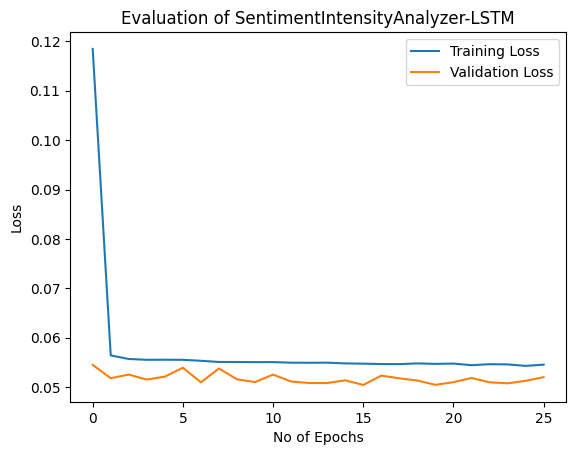

222/222 [==============================] - 1s 2ms/step


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X = df.drop(['Date', 'Price'], axis=1)
y = df['Price']

# Create a separate variable for the indices
indices = df.index.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, random_state=42)
y_test_actual = y_test

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train.reshape((y_train.shape[0], 1)),
                    epochs=100, batch_size=32, validation_data=(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test.reshape((y_test.shape[0], 1))), callbacks=[es])

# Evaluate the model
scores = model.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test.reshape((y_test.shape[0], 1)))
print('MSE: ', scores)

# Plot accuracy and validation loss for each epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.title('Evaluation of SentimentIntensityAnalyzer-LSTM')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))


MSE:  0.05201537162065506


<Figure size 640x480 with 0 Axes>

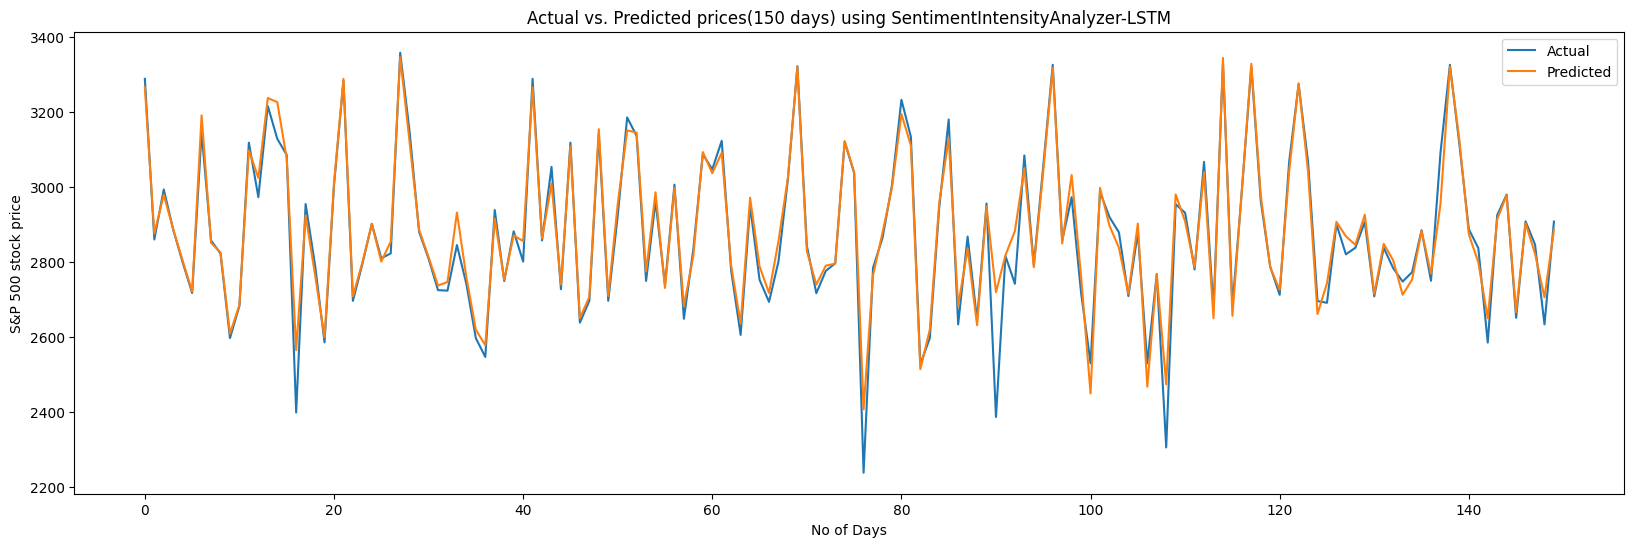

In [ ]:
y_test_scaled_back = scaler.inverse_transform(y_test)
y_pred_scaled_back = scaler.inverse_transform(y_pred)

# Print the MSE and plot the actual vs predicted values
print('MSE: ', scores)
plt.clf()
plt.figure(figsize=(20,6))
plt.plot(y_test_scaled_back[:150], label='Actual')
plt.plot(y_pred_scaled_back[:150], label='Predicted')
plt.xlabel('No of Days')
plt.ylabel('S&P 500 stock price')
plt.title('Actual vs. Predicted prices(150 days) using SentimentIntensityAnalyzer-LSTM')
plt.legend()
plt.show()

Data consolidated as an Average into approximately 136 weeks - Weekly Moving Average


*Actual vs. Predicted prices (136 weeks : 2017-12-11 to 2020-07-19)*


<Figure size 640x480 with 0 Axes>

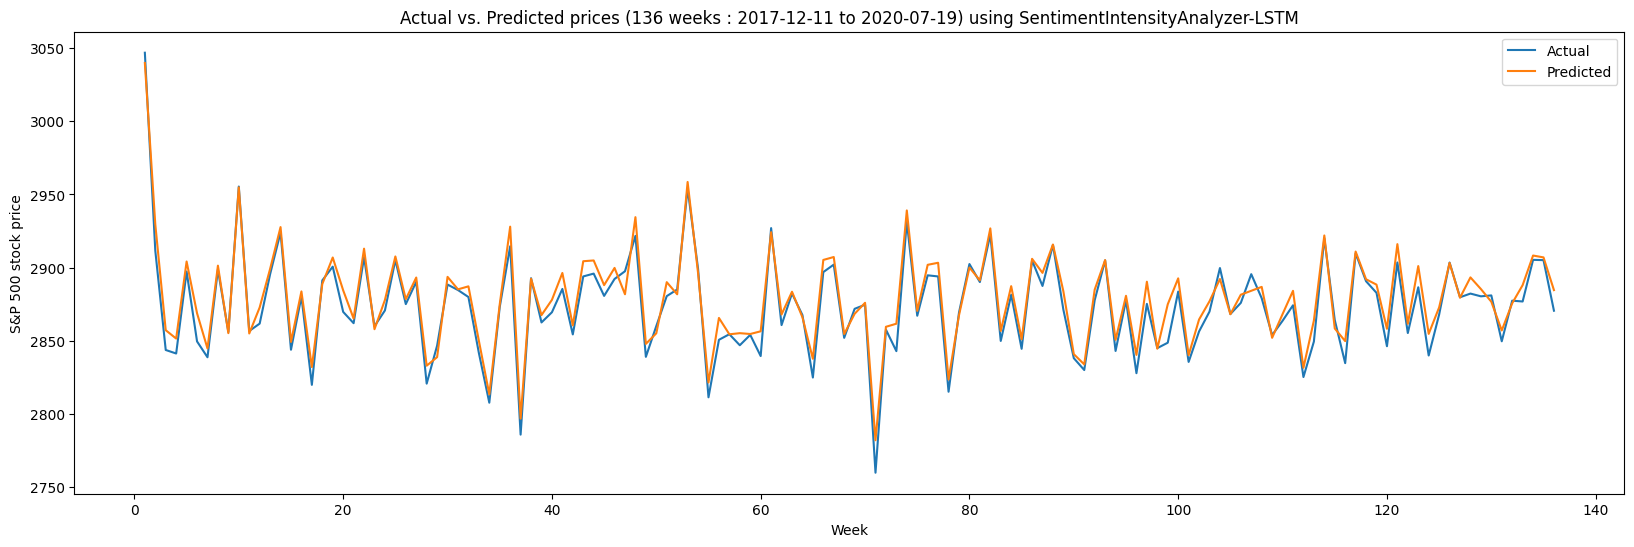

In [ ]:
# Create a DataFrame with the sorted actual and predicted values.
dates = df.loc[indices_test].sort_values('Date')['Date']
df_pred = pd.DataFrame({'date': dates, 'actual': y_test_scaled_back.flatten(), 'predicted': y_pred_scaled_back.flatten()})

# Group the DataFrame by week and calculate the mean values for each week
df_pred['week'] = pd.to_datetime(df_pred['date']).dt.to_period('W').astype(str)
df_pred = df_pred.groupby('week').mean()

# Convert the week index to integers
week_index = range(1, len(df_pred.index)+1)


# Plot the actual and predicted values for each week
plt.clf()
plt.figure(figsize=(20,6))
plt.plot(week_index, df_pred['actual'], label='Actual')
plt.plot(week_index, df_pred['predicted'], label='Predicted')
plt.xlabel('Week')
plt.ylabel('S&P 500 stock price')
plt.title('Actual vs. Predicted prices (136 weeks : 2017-12-11 to 2020-07-19) using SentimentIntensityAnalyzer-LSTM')
plt.legend()
plt.show()

Checking the accuracy of the model on the secondary Test set

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

X = test_set.drop(['Date', 'Price'], axis=1)
y = test_set['Price']

# Scale the input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Make predictions on the new data
y_pred = model.predict(X.reshape((X.shape[0], X.shape[1], 1)))

# Scale the predicted values back to their original range
y_scaler = StandardScaler()
y = test_set['Price']
y = np.array(y).reshape(-1, 1)
y_scaler.fit(y)
y_pred = y_scaler.inverse_transform(y_pred)

# Print the predicted values
print(y_pred)

157/157 [==============================] - 0s 2ms/step
[[3115.969 ]
 [2522.5605]
 [2727.539 ]
 ...
 [2675.3638]
 [2928.8481]
 [3383.1296]]


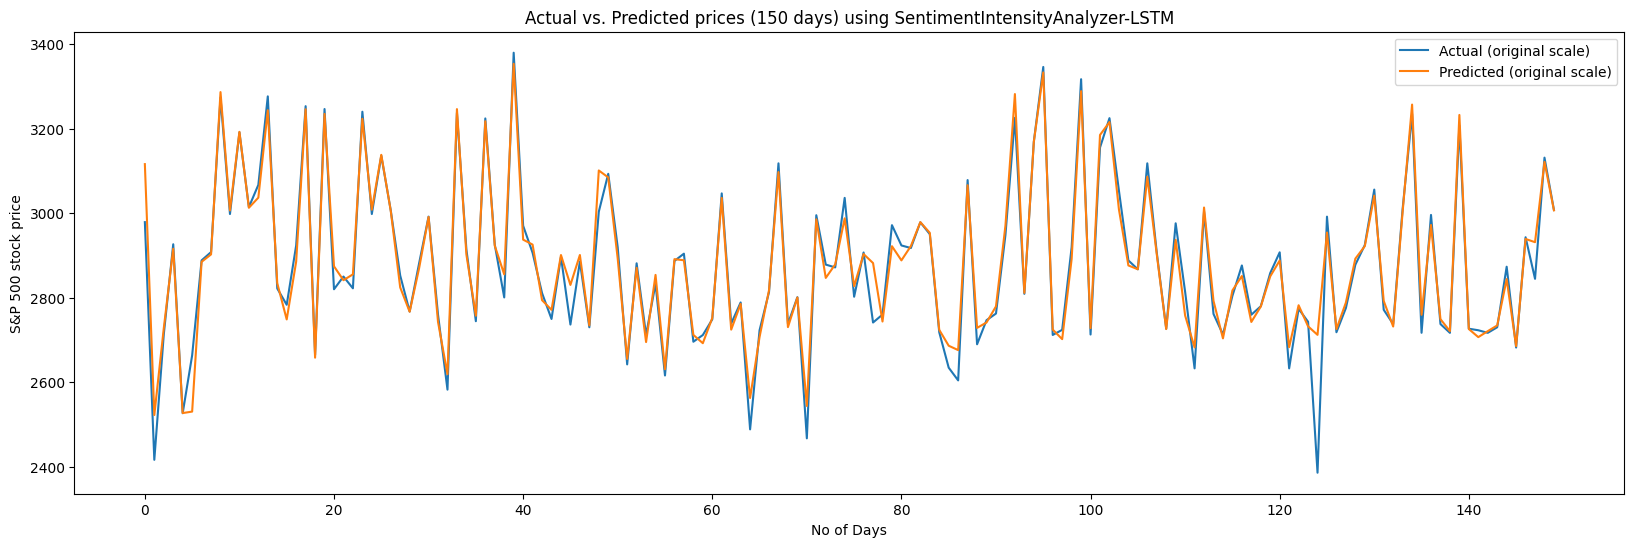

In [ ]:
# Plot the actual and predicted values for the first 150 dates
plt.figure(figsize=(20,6))
plt.plot(y[:150], label='Actual (original scale)')
plt.plot(y_pred[:150], label='Predicted (original scale)')
plt.xlabel('No of Days')
plt.ylabel('S&P 500 stock price')
plt.title('Actual vs. Predicted prices (150 days) using SentimentIntensityAnalyzer-LSTM')
plt.legend()
plt.show()

# **CROSS VALIDATION ON SentimentIntensityAnalyzer-LSTM MODEL**

---



Epoch 1/100
887/887 [==============================] - 9s 7ms/step - loss: 0.1154 - val_loss: 0.0569
Epoch 2/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0557 - val_loss: 0.0505
Epoch 3/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0553 - val_loss: 0.0506
Epoch 4/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0552 - val_loss: 0.0516
Epoch 5/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0549 - val_loss: 0.0505
Epoch 6/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0550 - val_loss: 0.0523
Epoch 7/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0550 - val_loss: 0.0532
Epoch 8/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0549 - val_loss: 0.0512
Epoch 9/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0547 - val_loss: 0.0521
Epoch 10/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0552 - val_lo

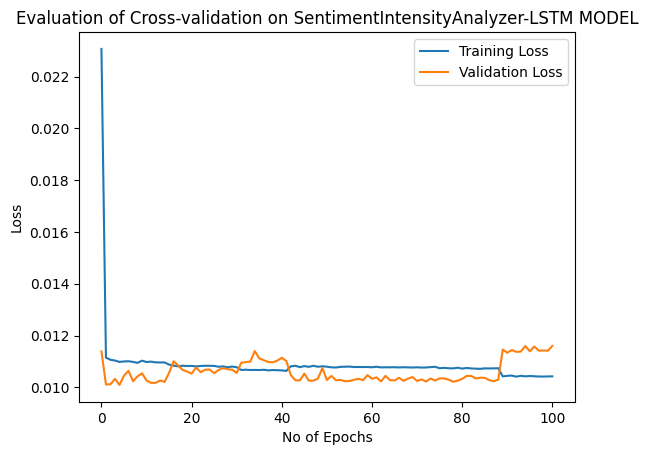

222/222 [==============================] - 1s 2ms/step


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

df = crossdf

# Split the data into input and target variables
X = df.drop(['Date', 'Price'], axis=1)
y = df['Price']

# Create a separate variable for the indices
indices = df.index.values

from sklearn.preprocessing import StandardScaler

# Scale the input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Scale the target variable
y = np.array(y).reshape(-1, 1)
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y).flatten()

# Define KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping and cross-validation
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train.reshape((y_train.shape[0], 1)),
                        epochs=100, batch_size=32, validation_data=(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test.reshape((y_test.shape[0], 1))), callbacks=[es])
    history.append(model_history)

# Evaluate the model
scores = model.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test.reshape((y_test.shape[0], 1)))
print('MSE: ', scores)

# Plot accuracy and validation loss for each epoch
train_losses = []
val_losses = []
for hist in history:
    train_losses.append(hist.history['loss'])
    val_losses.append(hist.history['val_loss'])

train_losses = np.mean(np.array(train_losses), axis=0)
val_losses = np.mean(np.array(val_losses), axis=0)

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.title('Evaluation of Cross-validation on SentimentIntensityAnalyzer-LSTM MODEL')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

X = test_set.drop(['Date', 'Price'], axis=1)
y = test_set['Price']

# Scale the input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Make predictions on the new data
y_pred = model.predict(X.reshape((X.shape[0], X.shape[1], 1)))

# Scale the predicted values back to their original range
y_scaler = StandardScaler()
y = test_set['Price']
y = np.array(y).reshape(-1, 1)
y_scaler.fit(y)
y_pred = y_scaler.inverse_transform(y_pred)

# Print the predicted values
print(y_pred)


157/157 [==============================] - 0s 2ms/step
[[3113.1782]
 [2524.0212]
 [2725.6284]
 ...
 [2677.517 ]
 [2929.613 ]
 [3364.991 ]]


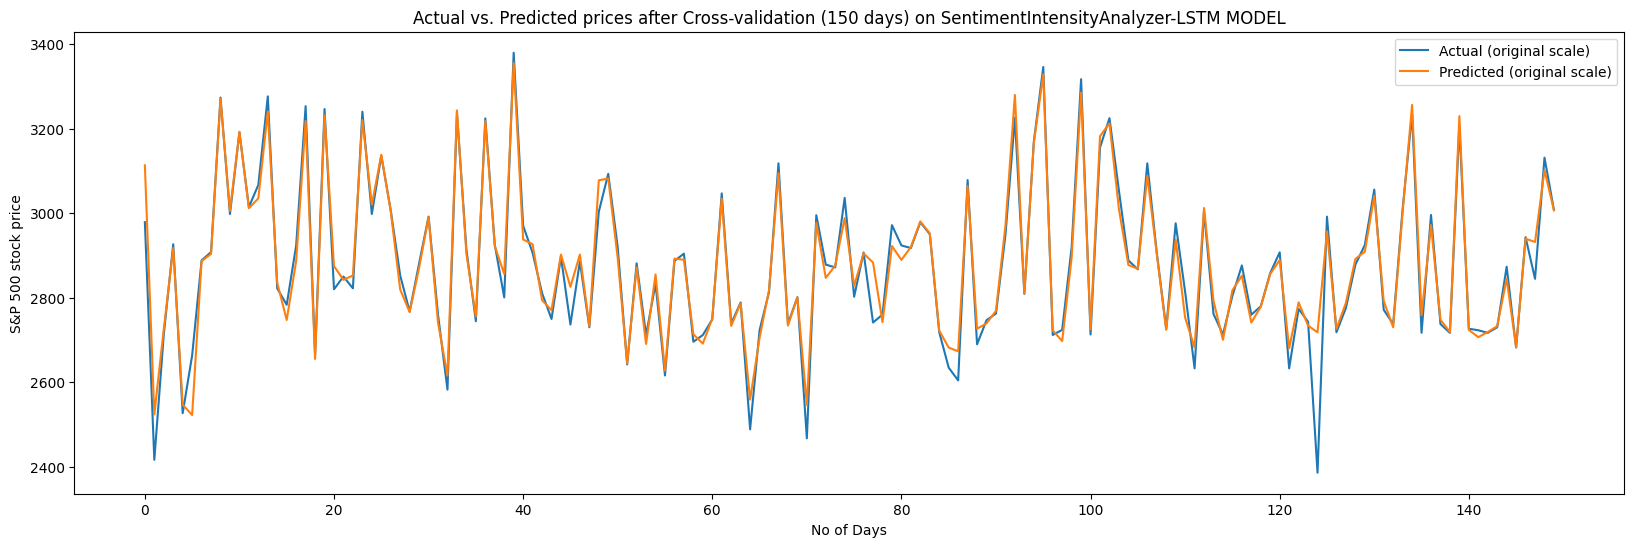

In [ ]:
# Plot the actual and predicted values for the first 150 dates
plt.figure(figsize=(20,6))
plt.plot(y[:150], label='Actual (original scale)')
plt.plot(y_pred[:150], label='Predicted (original scale)')
plt.xlabel('No of Days')
plt.ylabel('S&P 500 stock price')
plt.title('Actual vs. Predicted prices after Cross-validation (150 days) on SentimentIntensityAnalyzer-LSTM MODEL')
plt.legend()
plt.show()

# **Bidirectional Encoder Representations from Transformers (BERT)**

DataFrame for BERT without NA values

In [ ]:
df = maindf
df = df.dropna()

### Calculating Sentiment Scores using BERT

In [ ]:
!pip install transformers
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

df['source'] = df['source'].astype(str)
df['target'] = df['target'].astype(str)
entities = df['source'].str.cat(df['target'], sep=' ')
relationships = df['edge']

sentiment_scores = []

# Calculate sentiment scores for each headline
for headline in entities:
    # Tokenize the headline and convert to tensor
    encoded_headline = tokenizer.encode_plus(
        headline,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    encoded_headline = {key: tensor.to(device) for key, tensor in encoded_headline.items()}

    # Run the headline through the model and get the prediction
    with torch.no_grad():
        output = model(**encoded_headline)
        scores = output[0].detach().cpu().numpy()[0]
        sentiment_score = scores.argmax()

    sentiment_scores.append(sentiment_score)

# Add the sentiment scores to the dataframe
df['Sentiment Score Entity'] = sentiment_scores

sentiment_scores = []

# Calculate sentiment scores for each headline
for headline in relationships:
    # Tokenize the headline and convert to tensor
    encoded_headline = tokenizer.encode_plus(
        headline,
        max_length=128,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    encoded_headline = {key: tensor.to(device) for key, tensor in encoded_headline.items()}

    # Run the headline through the model and get the prediction
    with torch.no_grad():
        output = model(**encoded_headline)
        scores = output[0].detach().cpu().numpy()[0]
        sentiment_score = scores.argmax()

    sentiment_scores.append(sentiment_score)

# Add the sentiment scores to the dataframe
df['Sentiment Score Relation'] = sentiment_scores

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Define the DataFrame for traing, Sample 5000 random rows for secodary testing.

In [ ]:
df = df[['Date', 'Sentiment Score Entity', 'Sentiment Score Relation','prevclose', 'Price']]
test_set = df.sample(n=5000, random_state=42)
df = df.drop(test_set.index)
crossdf = df

# **BERT-LSTM**

Epoch 1/100
887/887 [==============================] - 12s 8ms/step - loss: 0.1113 - val_loss: 0.0528
Epoch 2/100
887/887 [==============================] - 8s 9ms/step - loss: 0.0549 - val_loss: 0.0537
Epoch 3/100
887/887 [==============================] - 6s 6ms/step - loss: 0.0547 - val_loss: 0.0510
Epoch 4/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0546 - val_loss: 0.0516
Epoch 5/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0544 - val_loss: 0.0502
Epoch 6/100
887/887 [==============================] - 5s 5ms/step - loss: 0.0544 - val_loss: 0.0503
Epoch 7/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0544 - val_loss: 0.0503
Epoch 8/100
887/887 [==============================] - 5s 5ms/step - loss: 0.0543 - val_loss: 0.0521
Epoch 9/100
887/887 [==============================] - 5s 5ms/step - loss: 0.0543 - val_loss: 0.0508
Epoch 10/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0542 - val_l

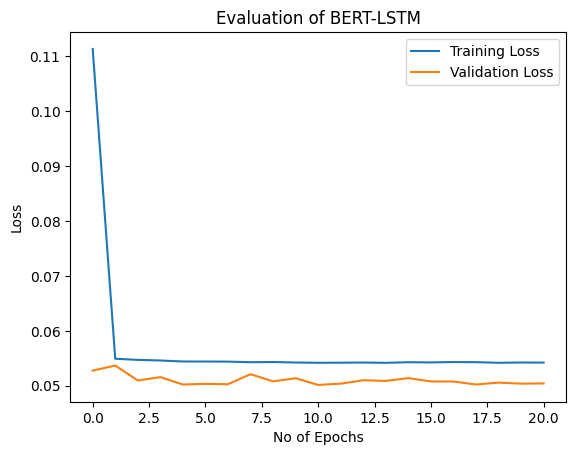

222/222 [==============================] - 1s 2ms/step


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X = df.drop(['Date', 'Price'], axis=1)
y = df['Price']

# Create a separate variable for the indices
indices = df.index.values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, random_state=42)
y_test_actual = y_test

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)
y_train = scaler.fit_transform(y_train)
y_test = scaler.fit_transform(y_test)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train.reshape((y_train.shape[0], 1)),
                    epochs=100, batch_size=32, validation_data=(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test.reshape((y_test.shape[0], 1))), callbacks=[es])

# Evaluate the model
scores = model.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test.reshape((y_test.shape[0], 1)))
print('MSE: ', scores)

# Plot accuracy and validation loss for each epoch
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.title('Evaluation of BERT-LSTM')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))



MSE:  0.05042380839586258


<Figure size 640x480 with 0 Axes>

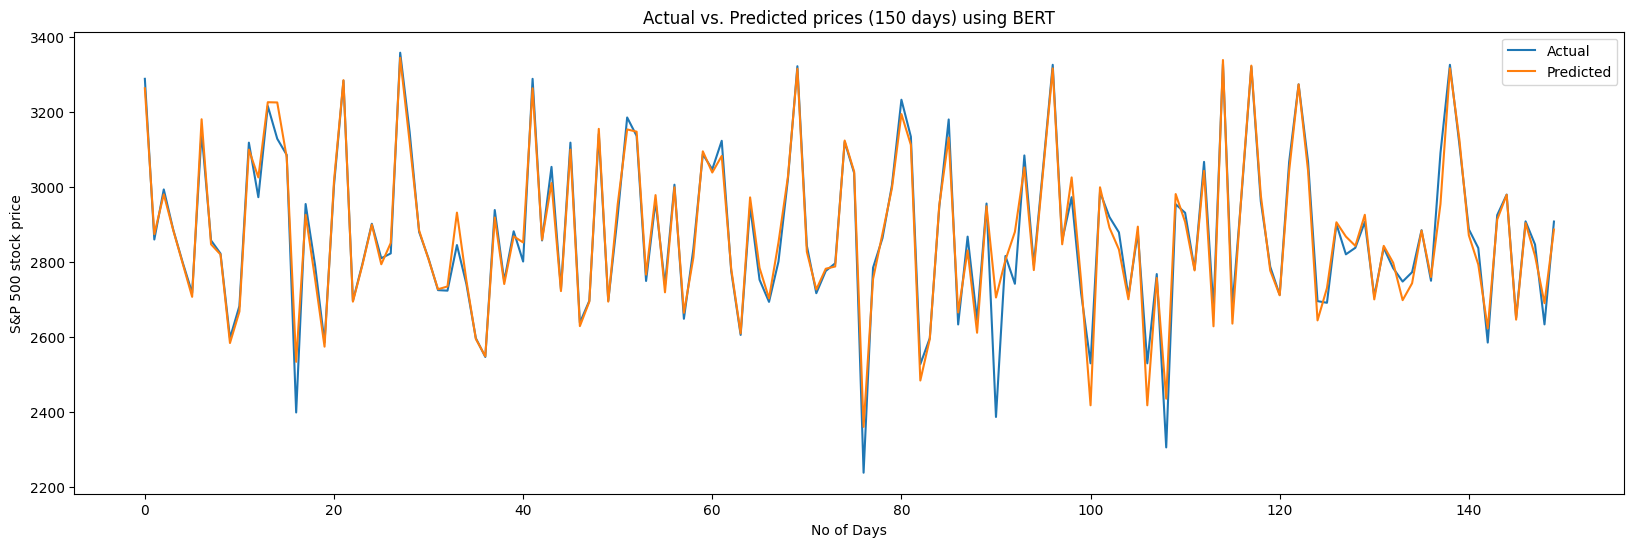

In [ ]:
y_test_scaled_back = scaler.inverse_transform(y_test)
y_pred_scaled_back = scaler.inverse_transform(y_pred)

# Print the MSE and plot the actual vs predicted values
print('MSE: ', scores)
plt.clf()
plt.figure(figsize=(20,6))
plt.plot(y_test_scaled_back[:150], label='Actual')
plt.plot(y_pred_scaled_back[:150], label='Predicted')
plt.xlabel('No of Days')
plt.ylabel('S&P 500 stock price')
plt.title('Actual vs. Predicted prices (150 days) using BERT')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

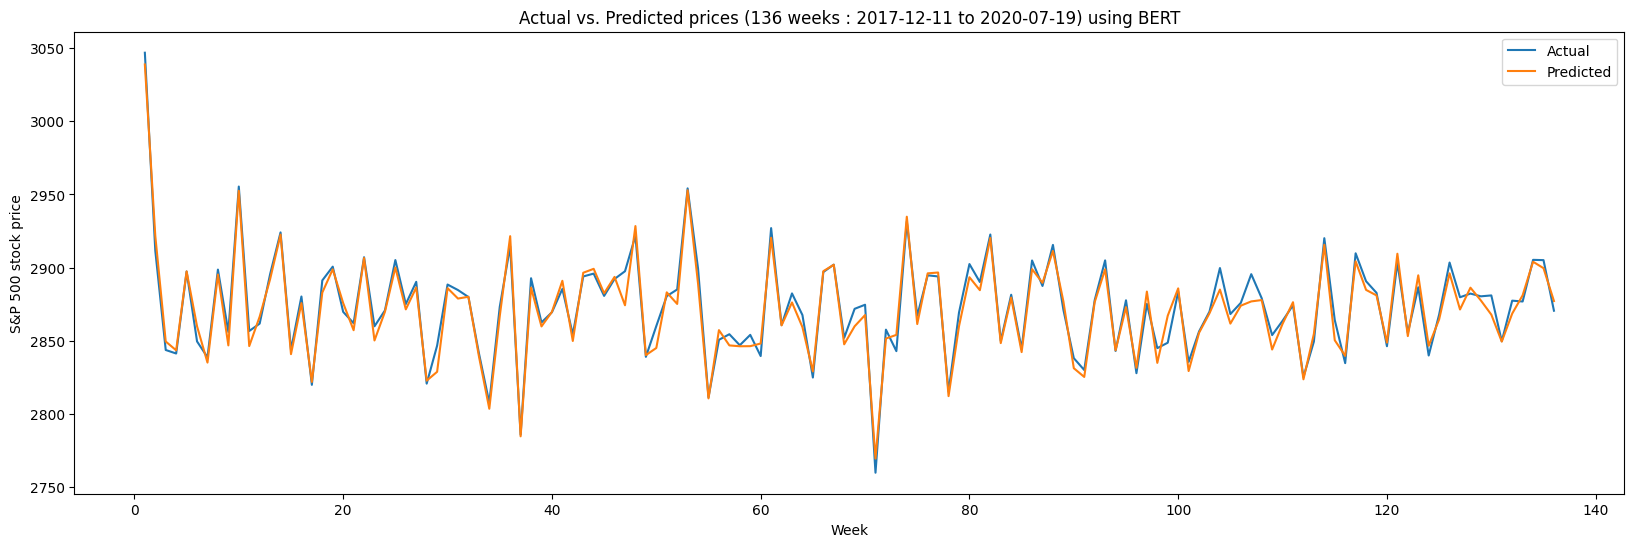

In [ ]:
# Create a DataFrame with the sorted actual and predicted values.
dates = df.loc[indices_test].sort_values('Date')['Date']
df_pred = pd.DataFrame({'date': dates, 'actual': y_test_scaled_back.flatten(), 'predicted': y_pred_scaled_back.flatten()})

# Group the DataFrame by week and calculate the mean values for each week
df_pred['week'] = pd.to_datetime(df_pred['date']).dt.to_period('W').astype(str)
df_pred = df_pred.groupby('week').mean()

# Convert the week index to integers
week_index = range(1, len(df_pred.index)+1)


# Plot the actual and predicted values for each week
plt.clf()
plt.figure(figsize=(20,6))
plt.plot(week_index, df_pred['actual'], label='Actual')
plt.plot(week_index, df_pred['predicted'], label='Predicted')
plt.xlabel('Week')
plt.ylabel('S&P 500 stock price')
plt.title('Actual vs. Predicted prices (136 weeks : 2017-12-11 to 2020-07-19) using BERT')
plt.legend()
plt.show()


Checking the accuracy of the model on the secondary Test set

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

X = test_set.drop(['Date', 'Price'], axis=1)
y = test_set['Price']

# Scale the input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Make predictions on the new data
y_pred = model.predict(X.reshape((X.shape[0], X.shape[1], 1)))

# Scale the predicted values back to their original range
y_scaler = StandardScaler()
y = test_set['Price']
y = np.array(y).reshape(-1, 1)
y_scaler.fit(y)
y_pred = y_scaler.inverse_transform(y_pred)

# Print the predicted values
print(y_pred)

157/157 [==============================] - 0s 2ms/step
[[3119.9465]
 [2483.1213]
 [2716.58  ]
 ...
 [2660.4595]
 [2931.1936]
 [3371.4854]]


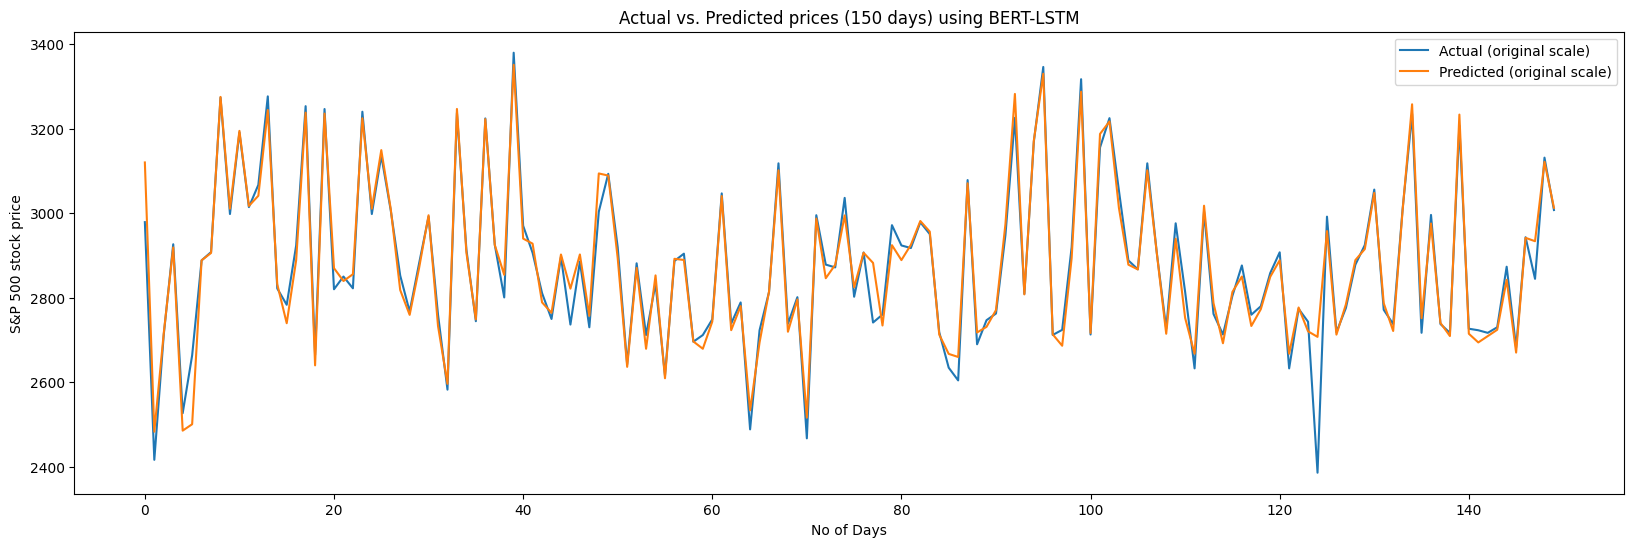

In [ ]:
# Plot the actual and predicted values for the first 150 dates
plt.figure(figsize=(20,6))
plt.plot(y[:150], label='Actual (original scale)')
plt.plot(y_pred[:150], label='Predicted (original scale)')
plt.xlabel('No of Days')
plt.ylabel('S&P 500 stock price')
plt.title('Actual vs. Predicted prices (150 days) using BERT-LSTM')
plt.legend()
plt.show()

# **CROSS VALIDATION ON BERT-LSTM MODEL**

Epoch 1/100
887/887 [==============================] - 9s 7ms/step - loss: 0.1095 - val_loss: 0.0518
Epoch 2/100
887/887 [==============================] - 5s 5ms/step - loss: 0.0547 - val_loss: 0.0514
Epoch 3/100
887/887 [==============================] - 5s 5ms/step - loss: 0.0545 - val_loss: 0.0504
Epoch 4/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0545 - val_loss: 0.0506
Epoch 5/100
887/887 [==============================] - 5s 5ms/step - loss: 0.0546 - val_loss: 0.0523
Epoch 6/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0543 - val_loss: 0.0511
Epoch 7/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0544 - val_loss: 0.0507
Epoch 8/100
887/887 [==============================] - 5s 5ms/step - loss: 0.0543 - val_loss: 0.0507
Epoch 9/100
887/887 [==============================] - 5s 6ms/step - loss: 0.0544 - val_loss: 0.0503
Epoch 10/100
887/887 [==============================] - 5s 5ms/step - loss: 0.0543 - val_lo

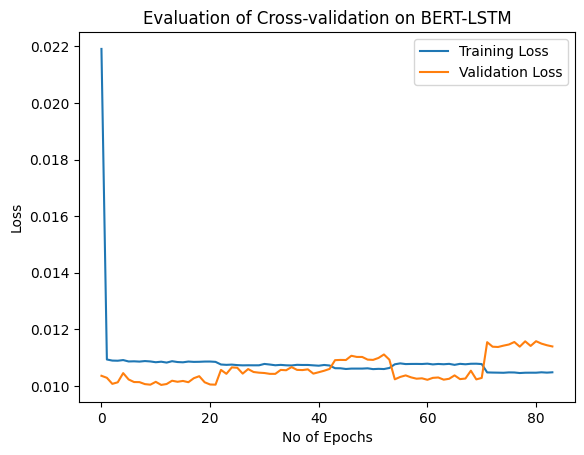

222/222 [==============================] - 1s 2ms/step


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

df = crossdf

# Split the data into input and target variables
X = df.drop(['Date', 'Price'], axis=1)
y = df['Price']

# Create a separate variable for the indices
indices = df.index.values

from sklearn.preprocessing import StandardScaler

# Scale the input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Scale the target variable
y = np.array(y).reshape(-1, 1)
y_scaler = StandardScaler()
y = y_scaler.fit_transform(y).flatten()

# Define KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model with early stopping and cross-validation
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model_history = model.fit(X_train.reshape((X_train.shape[0], X_train.shape[1], 1)), y_train.reshape((y_train.shape[0], 1)),
                        epochs=100, batch_size=32, validation_data=(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test.reshape((y_test.shape[0], 1))), callbacks=[es])
    history.append(model_history)

# Evaluate the model
scores = model.evaluate(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)), y_test.reshape((y_test.shape[0], 1)))
print('MSE: ', scores)

# Plot accuracy and validation loss for each epoch
train_losses = []
val_losses = []
for hist in history:
    train_losses.append(hist.history['loss'])
    val_losses.append(hist.history['val_loss'])

train_losses = np.mean(np.array(train_losses), axis=0)
val_losses = np.mean(np.array(val_losses), axis=0)

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.title('Evaluation of Cross-validation on BERT-LSTM')
plt.legend()
plt.show()

# Make predictions on the test set
y_pred = model.predict(X_test.reshape((X_test.shape[0], X_test.shape[1], 1)))

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

X = test_set.drop(['Date', 'Price'], axis=1)
y = test_set['Price']

# Scale the input features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Make predictions on the new data
y_pred = model.predict(X.reshape((X.shape[0], X.shape[1], 1)))

# Scale the predicted values back to their original range
y_scaler = StandardScaler()
y = test_set['Price']
y = np.array(y).reshape(-1, 1)
y_scaler.fit(y)
y_pred = y_scaler.inverse_transform(y_pred)

# Print the predicted values
print(y_pred)


157/157 [==============================] - 0s 2ms/step
[[3113.8865]
 [2497.5537]
 [2720.327 ]
 ...
 [2665.8186]
 [2929.3936]
 [3363.779 ]]


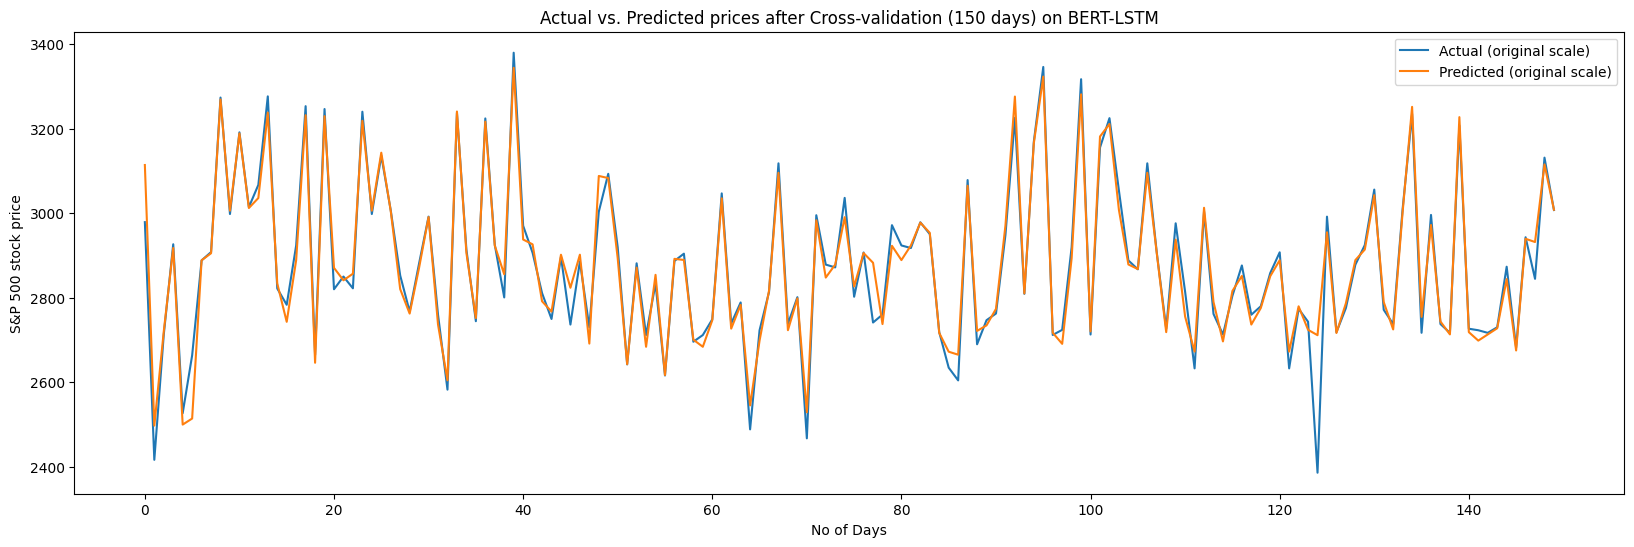

In [ ]:
# Plot the actual and predicted values for the first 150 dates
plt.figure(figsize=(20,6))
plt.plot(y[:150], label='Actual (original scale)')
plt.plot(y_pred[:150], label='Predicted (original scale)')
plt.xlabel('No of Days')
plt.ylabel('S&P 500 stock price')
plt.title('Actual vs. Predicted prices after Cross-validation (150 days) on BERT-LSTM')
plt.legend()
plt.show()